In [43]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
import time
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
%%time
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test.csv")

CPU times: user 1.3 s, sys: 123 ms, total: 1.42 s
Wall time: 1.42 s


In [16]:
train.tail()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,sum_hist_trans,mean_hist_trans,std_hist_trans,...,binned_mean_hist_trans,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans,binned_sum_merch_trans,binned_mean_merch_trans,year,month
76423,2017-01-01,C_ID_b61441db3a,4,1,0,-4.454597,396,-223.710275,-0.581066,0.242968,...,"(-0.587, -0.537]",-9.929143,-0.496457,0.298798,-0.724368,0.455213,"(-70.813, -8.882]","(-0.565, -0.487]",2017,1
76424,2017-05-01,C_ID_c237fdb700,5,2,1,-4.212957,276,-0.624667,-0.044619,1.560035,...,"(-0.265, 500883.005]",3.180902,1.590451,3.286399,-0.733384,3.914286,"(-0.578, 109.086]","(-0.296, 44.182]",2017,5
76425,2017-03-01,C_ID_1f7705995d,4,1,0,-1.536847,337,-27.494595,-0.392780,1.186955,...,"(-0.454, -0.265]",-0.675412,-0.675412,NaN,-0.675412,-0.675412,"(-0.739, -0.578]","(-0.684, -0.665]",2017,3
76426,2017-03-01,C_ID_6ddb1fbb87,3,3,1,0.905767,337,-26.427066,-0.660677,0.103918,...,"(-0.67, -0.648]",-5.444646,-0.680581,0.044790,-0.736975,-0.599648,"(-6.139, -4.574]","(-0.684, -0.665]",2017,3
76427,2014-08-01,C_ID_42b96343cf,3,3,1,2.523713,1280,-5.794073,-0.643786,0.043565,...,"(-0.648, -0.621]",-1.325774,-0.662887,0.008256,-0.668725,-0.657049,"(-1.396, -0.739]","(-0.665, -0.642]",2014,8


In [22]:
target = train['target']
del train['target']

In [23]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'elapsed_time', 'sum_hist_trans', 'mean_hist_trans', 'std_hist_trans',
       'min_hist_trans', 'max_hist_trans', 'binned_sum_hist_trans',
       'binned_mean_hist_trans', 'sum_merch_trans', 'mean_merch_trans',
       'std_merch_trans', 'min_merch_trans', 'max_merch_trans',
       'binned_sum_merch_trans', 'binned_mean_merch_trans', 'year', 'month'],
      dtype='object')

In [24]:
test.tail()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans,year,month
123618,2017-10-01,C_ID_7a239d2eda,2,2,0,123.0,-49.404782,-0.676778,0.045208,-0.732197,-0.525387,NaN,NaN,NaN,NaN,NaN,2017.0,10.0
123619,2017-09-01,C_ID_75ace375ae,3,1,1,153.0,-4.914616,-0.702088,0.056440,-0.736404,-0.578911,-2.658701,-0.664675,0.091129,-0.740897,-0.536687,2017.0,9.0
123620,2016-09-01,C_ID_21d56d950c,5,1,1,518.0,-6.583716,-0.177938,0.520933,-0.698853,1.664306,NaN,NaN,NaN,NaN,NaN,2016.0,9.0
123621,2017-06-01,C_ID_6c46fc5a9d,2,1,0,245.0,-39.123627,-0.631026,0.104634,-0.737892,-0.115794,-3.779889,-0.629981,0.074584,-0.707839,-0.498970,2017.0,6.0
123622,2016-10-01,C_ID_87e7979a5f,5,1,1,488.0,-25.314203,-0.602719,0.248142,-0.724654,0.470089,-0.498970,-0.498970,NaN,-0.498970,-0.498970,2016.0,10.0


In [35]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month', 'binned_sum_hist_trans', 'binned_mean_hist_trans', 'binned_sum_merch_trans', 'binned_mean_merch_trans']]
categorical_feats = ['feature_2', 'feature_3']

In [26]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [47]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold 0


/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.80442	valid_1's rmse: 3.85705
[200]	training's rmse: 3.78241	valid_1's rmse: 3.84545
[300]	training's rmse: 3.76752	valid_1's rmse: 3.8401
[400]	training's rmse: 3.75601	valid_1's rmse: 3.83753
[500]	training's rmse: 3.74687	valid_1's rmse: 3.8363
[600]	training's rmse: 3.73903	valid_1's rmse: 3.83582
[700]	training's rmse: 3.73182	valid_1's rmse: 3.83538
[800]	training's rmse: 3.72572	valid_1's rmse: 3.83529
[900]	training's rmse: 3.71997	valid_1's rmse: 3.83535
[1000]	training's rmse: 3.71459	valid_1's rmse: 3.83543
Early stopping, best iteration is:
[841]	training's rmse: 3.7232	valid_1's rmse: 3.83523
fold 1


/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.82414	valid_1's rmse: 3.77734
[200]	training's rmse: 3.80216	valid_1's rmse: 3.76491
[300]	training's rmse: 3.78716	valid_1's rmse: 3.75888
[400]	training's rmse: 3.77586	valid_1's rmse: 3.75592
[500]	training's rmse: 3.76687	valid_1's rmse: 3.75418
[600]	training's rmse: 3.75892	valid_1's rmse: 3.75334
[700]	training's rmse: 3.75196	valid_1's rmse: 3.75292
[800]	training's rmse: 3.74577	valid_1's rmse: 3.75282
[900]	training's rmse: 3.74001	valid_1's rmse: 3.7527
[1000]	training's rmse: 3.7347	valid_1's rmse: 3.75259
[1100]	training's rmse: 3.7294	valid_1's rmse: 3.7528
Early stopping, best iteration is:
[985]	training's rmse: 3.73548	valid_1's rmse: 3.7525
fold 2


/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.8305	valid_1's rmse: 3.75194
[200]	training's rmse: 3.80885	valid_1's rmse: 3.73921
[300]	training's rmse: 3.79388	valid_1's rmse: 3.73311
[400]	training's rmse: 3.78251	valid_1's rmse: 3.73006
[500]	training's rmse: 3.77333	valid_1's rmse: 3.7286
[600]	training's rmse: 3.76574	valid_1's rmse: 3.72781
[700]	training's rmse: 3.75913	valid_1's rmse: 3.72763
[800]	training's rmse: 3.75307	valid_1's rmse: 3.72771
[900]	training's rmse: 3.74752	valid_1's rmse: 3.72762
Early stopping, best iteration is:
[739]	training's rmse: 3.75675	valid_1's rmse: 3.72753
fold 3


/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.77705	valid_1's rmse: 3.9611
[200]	training's rmse: 3.7545	valid_1's rmse: 3.95046
[300]	training's rmse: 3.73925	valid_1's rmse: 3.94599
[400]	training's rmse: 3.72786	valid_1's rmse: 3.9441
[500]	training's rmse: 3.71881	valid_1's rmse: 3.94321
[600]	training's rmse: 3.71144	valid_1's rmse: 3.94298
[700]	training's rmse: 3.70501	valid_1's rmse: 3.9429
[800]	training's rmse: 3.69906	valid_1's rmse: 3.94291
[900]	training's rmse: 3.69369	valid_1's rmse: 3.94313
Early stopping, best iteration is:
[733]	training's rmse: 3.70288	valid_1's rmse: 3.94284
fold 4


/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.82603	valid_1's rmse: 3.76793
[200]	training's rmse: 3.80358	valid_1's rmse: 3.75703
[300]	training's rmse: 3.78865	valid_1's rmse: 3.75205
[400]	training's rmse: 3.77723	valid_1's rmse: 3.74974
[500]	training's rmse: 3.76829	valid_1's rmse: 3.74867
[600]	training's rmse: 3.76056	valid_1's rmse: 3.74818
[700]	training's rmse: 3.75396	valid_1's rmse: 3.74799
[800]	training's rmse: 3.7479	valid_1's rmse: 3.74807
[900]	training's rmse: 3.74222	valid_1's rmse: 3.74825
Early stopping, best iteration is:
[746]	training's rmse: 3.75107	valid_1's rmse: 3.74792
CV score: 3.80204 


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


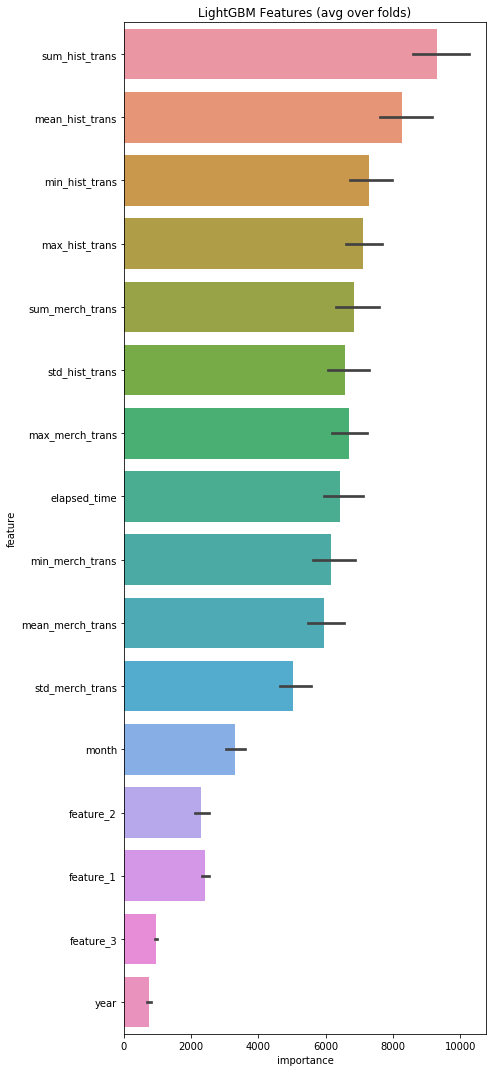

In [46]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(7,15))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [45]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

- score : 3.879
